In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

os.makedirs('./results', exist_ok=True)

with open('./brown_100.txt', 'r') as file_:
    corpus = file_.read()

def write_freqs(list_: list, filename: str) -> None:
    with open(f'./results/{filename}.txt', 'w') as file_:
        file_.write('\n'.join([' '.join(x[0]) + ' | ' + str(x[1]) for x in list_]))

## N-Gram Language Modeling
In the second assignment, you will implement an **n-gram language model** that processes input text to generate, analyze, and calculate the probabilities of sequences of `n` words (n-grams). This model will tokenize text, create n-grams, and compute their frequencies and probabilities, returning the most frequent n-grams in the text.

1. **Tokenization**: Convert the input text into a list of words (tokens).
2. **N-gram Generation**: Create sequences of `n` tokens from the text, treating each sentence independently with the inclusion of start (`<s>`) and end (`</s>`) markers.
3. **Frequency Counting**: Count how many times each n-gram appears in the text.
4. **Probability Calculation**: Compute the probabilities of each n-gram based on its frequency and add alpha smoothing to improve generalization of items.
5. **Most Frequent N-grams**: Return the most frequent n-grams along with their probabilities, helping to identify common patterns in the text.

In [2]:
from collections import Counter, defaultdict # You may import more from collections if needed

class NGramModel:
    def __init__(self, text, n, alpha=0.0):
        """
        Initialize the NGramModel with text and the value of n.
        """
        self.text = text
        self.n = n
        self.alpha = alpha  # Alpha value for additive smoothing
        self.ngrams = {}
        self.frequencies = {}
        self.probabilities = {}
        self.vocab = set()

    def tokenize(self) -> None:
        """
        Tokenize the text into words. 
        Fill in the code to split the text into a list of words.
        """
        contractions = ["n't", "'s", "'re", "'ve", "'ll", "'d", "'m", "'t"]
        new_tokens = []
        #clean tokens
        initial_tokens = self.text.split(" ")
        tokens = [token.lower() for token in initial_tokens] #make all tokens lower
        tokens = [token.strip() for token in tokens] #strip extra whitespcae
        #handles punctuations before and after string
        for token in tokens:
            matched_p = re.match(rf"^(\W*)([\w']+)(\W*)$",token)
            if matched_p:
                if matched_p.group(1):
                    new_tokens.append(matched_p.group(1))
                if matched_p.group(2):
                    new_tokens.append(matched_p.group(2))
                if matched_p.group(3):
                    new_tokens.append(matched_p.group(3))
                continue
            else:
                new_tokens.append(token)
        tokens=new_tokens
        new_tokens = []

        # handle contractions
        for token in tokens:
            cont_bool =False
            for contraction in contractions:
                matched_c = re.match(rf"^(\w+){contraction}$",token)
                if matched_c:
                    new_tokens.append(matched_c.group(1))
                    new_tokens.append(contraction)
                    cont_bool =True
                    break
            if cont_bool ==False:
                new_tokens.append(token)
        tokens = new_tokens
        self.vocab = set(tokens)
        return tokens

    def generate_ngrams(self, tokens: list) -> dict:
        """
        Generate n-grams from the list of tokens.
        Fill in the code to create n-grams.
        Make sure to treat each sentence independently, include the <s> and </s> tokens.
        """
        # total number of n_grams possible given list of tokens 
        num_ngrams = len(tokens) - self.n + 1

        for idx, token in enumerate(tokens[:num_ngrams]):
            
            ngram = ["<s>"] # init ngram
            # generate n-gram starting with current token 
            for t in tokens[idx: idx + self.n]:
                ngram.append(t)

            # add generated ngrams 
            self.ngrams.setdefault(token, []).append(" ".join(ngram + ["</s>"]))

        return self.ngrams

    def count_frequencies(self) -> None:
        """
        Count the frequencies of each n-gram.
        Fill in the code to count n-gram occurrences.
        """
        self.n_gram_freq = defaultdict(int)

        voc_list = list(self.vocab)

        #initializing frequencies 
        for w1 in voc_list:
            for w2 in voc_list:
                self.n_gram_freq[f"{w1} {w2}"] = 0
        
        for ngram_list in self.ngrams.values():
            for ngram_str in ngram_list:
                self.n_gram_freq[ngram_str] += 1

    def calculate_probabilities(self) -> None:
        """
        Calculate probabilities of each n-gram based on its frequency. Add alpha smoothing separately.
        """

        total_ngrams = sum(self.n_gram_freq.values())
        vocab_size = len(self.vocab)

        for ngram_str, count in self.n_gram_freq.items():
            smoothed_count = count + self.alpha
            smoothed_total = total_ngrams + self.alpha * vocab_size

            self.probabilities[ngram_str] = smoothed_count / smoothed_total


    def most_frequent_ngrams(self, top_n: int = 10) -> list:
        """
        Return the most frequent n-grams and their probabilities.
        """
        
        # Sort n-grams by frequency in descending order
        sorted_grams = sorted(self.n_gram_freq.items(), key=lambda x: x[1], reverse=True)
        return sorted_grams[:top_n]

# Testing the model with an example
text = "This is a simple example to demonstrate how n-grams work in this assignment." #Faster than running the full corpus
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(text, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()
# Print the most frequent n-grams
print(model.most_frequent_ngrams(200))

[('<s> this is </s>', 1), ('<s> this assignment </s>', 1), ('<s> is a </s>', 1), ('<s> a simple </s>', 1), ('<s> simple example </s>', 1), ('<s> example to </s>', 1), ('<s> to demonstrate </s>', 1), ('<s> demonstrate how </s>', 1), ('<s> how n-grams </s>', 1), ('<s> n-grams work </s>', 1), ('<s> work in </s>', 1), ('<s> in this </s>', 1), ('<s> assignment . </s>', 1), ('example example', 0), ('example work', 0), ('example in', 0), ('example demonstrate', 0), ('example n-grams', 0), ('example this', 0), ('example simple', 0), ('example how', 0), ('example a', 0), ('example to', 0), ('example is', 0), ('example .', 0), ('example assignment', 0), ('work example', 0), ('work work', 0), ('work in', 0), ('work demonstrate', 0), ('work n-grams', 0), ('work this', 0), ('work simple', 0), ('work how', 0), ('work a', 0), ('work to', 0), ('work is', 0), ('work .', 0), ('work assignment', 0), ('in example', 0), ('in work', 0), ('in in', 0), ('in demonstrate', 0), ('in n-grams', 0), ('in this', 0),

### Unigrams

In this section, we apply the `NGramModel` to our corpus. The model can be configured to generate unigrams, bigrams, or trigrams by adjusting the value of `n`. After tokenizing the text and generating the n-grams, the model counts the occurrences of each n-gram and calculates their probabilities. The most frequent n-grams are then written to an output file.

By adjusting the n-gram size, we can analyze different levels of word dependencies in the text, providing insights into common word sequences and patterns.  

The code below will generate unigrams when the NGramModel is implemented correctly

In [3]:
n = 1  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'unigrams')

### Bigrams
Bigrams allow us to explore word pairs and their relationships, providing insight into common word combinations and phrase structures within the corpus.  
The code below will generate bigrams when the NGramModel is implemented correctly.

In [4]:
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(807)[::-1], 'bigrams')

### Trigrams
Trigrams capture three-word sequences, providing a deeper understanding of longer word dependencies and commonly occurring phrases within the text.  
The code below will generate trigrams when the NGramModel is implemented correctly

In [5]:
n = 3  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(600)[::-1][:10], 'trigrams')

### Smoothing
Below, we generate **bigrams** with **smoothing** applied by setting `n = 2` and including a smoothing parameter `alpha = 1.0`. Smoothing is useful in language models to handle unseen n-grams by assigning a small probability to them. The model tokenizes the text, generates bigrams, counts their frequencies, and calculates smoothed probabilities. The most frequent bigrams are then written to an output file.





In [6]:
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n, alpha=10)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(800)[::-1], 'bigrams_smoothed')

### Generating Text
In this example, we generate text using the **bigrams** model by providing a starting **prompt** (e.g., "the jury"). The `generate_text` function creates a sequence of words based on the trained bigram model, starting from the provided prompt and continuing based on the probabilities of the next words.

After tokenizing the corpus, generating bigrams, and calculating their frequencies and probabilities, the model uses these learned probabilities to generate text. The generated output is then written to a file.

Text generation with n-grams helps illustrate how language models can predict word sequences, allowing us to create new sentences that follow similar patterns found in the original text.

In [7]:
def generate_text(model: NGramModel, n: int, prompt: str) -> str:
    # create list of tokens incluing prompt tokens
    gen_tokens = []
    
    # generate tokens 
    for i in range(n):

        # fetch current token
        current_token = gen_tokens[-1] if len(gen_tokens) != 0 else prompt.split(" ")[-1]
        # get ngrams for last token
        token_ngram = model.ngrams[current_token]
        # next token mask
        next_token = (None, 0) # (token, prob)

        # loop over ngrams and select the one with highest probability
        for ngram in token_ngram:
            # print(f"ngram: {ngram}, prob.: {model.probabilities[ngram]}")
            # update token based on prob 
            if model.probabilities[ngram] > next_token[1]:
                next_token = (ngram.split(" ")[-2], model.probabilities[ngram])
        
        # append most probable word to generated tokens list
        gen_tokens.append(next_token[0])


    return ' '.join(gen_tokens)


tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()
generated_text = generate_text(model, 2, 'the jury')
with open(f'./results/generated_bigrams.txt', 'w') as file_:
    file_.write(generated_text)

## Word Vectors
Based on the Stanford course: https://web.stanford.edu/class/cs224n/

### Count based W2V
In this section, we use the previously trained **n-gram model** to calculate a **co-occurrence matrix**. A co-occurrence matrix shows how often words appear together within a specific context (in this case, bigrams), providing insights into word relationships in the corpus.

Steps:
1. **Tokenization and N-gram Generation**: We first tokenize the text and generate bigrams using the `NGramModel`.
2. **Vocabulary and Indexing**: The vocabulary is created from the unique tokens, and a word-to-index mapping is established.
3. **Co-occurrence Matrix**: Using the generated n-grams, we compute the co-occurrence matrix, where each entry represents how often two words occur together within the bigrams.

The co-occurrence matrix provides a numerical representation of word relationships, which is useful for tasks like word embeddings, semantic analysis, and understanding word associations.

In [8]:
# Since we already have a working ngram model, for the next part we can use the ngrams to calculate the co-occurences.
model = NGramModel(corpus, 2)
tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)

def create_co_matrix(ngrams: dict, vocab_size: int, word_to_index: dict) -> np.ndarray:
    # create co_matrix
    co_matrix = np.zeros((vocab_size, vocab_size))

    # remove faulty tokens 
    keys_to_remove = ["<", ">", "/", "s"]
    for key in keys_to_remove:
        ngrams.pop(key, None)

    # flatten ngrams
    flat_grams = [re.sub(r"</?s>", "", v).strip() for value in ngrams.values() for v in value]
    
    for ng in flat_grams:
        
        #  extract words from bigram
        first, second =  ng.split(" ")
        # get indices for words
        idx_f, idx_s = word_to_index[first], word_to_index[second]
        # print(f"Fist: {first}, idx: {idx_f}")

        # update co_matrix 
        co_matrix[idx_f][idx_s] += 1 
        co_matrix[idx_s][idx_f] += 1

    return co_matrix

vocab = list(set(tokens))
vocab_size = len(vocab)

# Create a word-to-index mapping
word_to_index = {word: idx for idx, word in enumerate(vocab)}

# Generate the co-occurrence matrix
co_matrix = create_co_matrix(ngrams, vocab_size, word_to_index)

# Optionally, print the matrix or parts of it
# print(pd.DataFrame(co_matrix).value_counts)

# for idx1, vect in enumerate(co_matrix):
#     for idx2, cell in enumerate(vect):
#         if cell != 0.0:
#             print(f"({idx1},{idx2})")


With the code below you can verify if the co-occurence works

In [9]:
def check_co_occurrence(word1, word2, co_matrix, word_to_index):
    """
    Print the co-occurrence count for a specific word pair.
    """
    if word1 not in word_to_index or word2 not in word_to_index:
        print(f"One or both words '{word1}' and '{word2}' are not in the vocabulary.")
        return

    index1 = word_to_index[word1]
    index2 = word_to_index[word2]

    co_count = co_matrix[index1][index2]
    print(f"Co-occurrence count for '{word1}' and '{word2}': {co_count}")

check_co_occurrence('the', 'jury', co_matrix, word_to_index)
check_co_occurrence('the', 'cat', co_matrix, word_to_index)

Co-occurrence count for 'the' and 'jury': 13.0
One or both words 'the' and 'cat' are not in the vocabulary.


In this part, we reduce the dimensionality of the **co-occurrence matrix** using **Singular Value Decomposition (SVD)**. This technique helps in extracting the most important features from the matrix, making it easier to visualize and interpret the relationships between words.

Steps:
1. **Singular Value Decomposition (SVD)**: The co-occurrence matrix is decomposed into three matrices: \( M = U \cdot \Sigma \cdot V^T \).
2. **Dimensionality Reduction**: We retain only the top `k` components (default is 2) from the SVD, effectively reducing the dimensionality of the matrix.
3. **Reduced Matrix**: The reduced matrix retains the most important semantic information and can be used for tasks such as **word embedding visualization** or **semantic similarity analysis**.

Dimensionality reduction allows us to capture the essence of word relationships in fewer dimensions, making it more efficient to process and visualize the data.

In [10]:
def reduce_to_k_dim(M, k=2):
    # do singualr value decomposition
    U, Z, Vt = np.linalg.svd(M)

    # dimensionality reduction
    U_k = U[:, : k]
    Z_k = np.diag(Z[:k])
    Vt_k = Vt[: k, :]

    # matrix reconstruction
    M_reduced = U_k @  Z_k @ Vt_k

    return M_reduced

In this final part, we visualize the reduced word embeddings in **2D space**. After reducing the dimensionality of the co-occurrence matrix using SVD, we plot the embeddings for each word to observe their relationships in a low-dimensional space.

Steps:
1. **Plotting the Embeddings**: Each word from the vocabulary is plotted based on its 2D coordinates from the reduced matrix.
2. **Visualization**: The scatter plot allows us to see how words cluster together or relate to each other based on co-occurrences in the text. Words with similar contexts should appear closer to each other in the plot.
3. **Interpretation**: By looking at the 2D plot, we can analyze word similarities, relationships, and clusters formed by words that often occur together.

This visualization is a useful tool for understanding the structure of word embeddings and the relationships between words in the corpus.







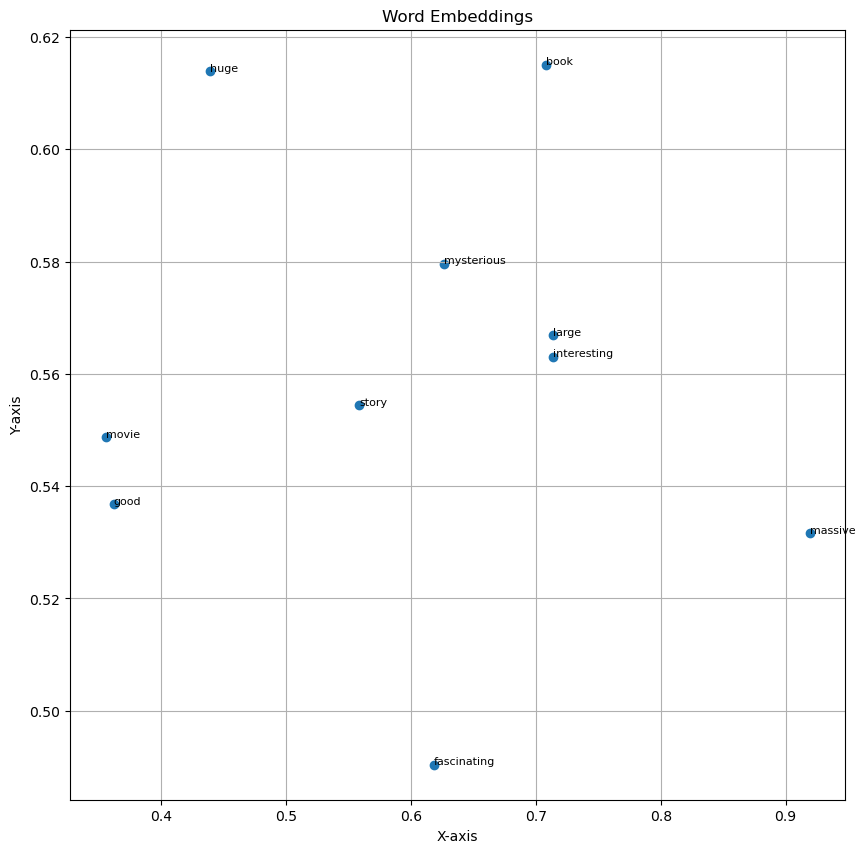

In [11]:
def plot_embeddings(M_reduced, vocab):
    plt.figure(figsize=(10, 10))
    plt.scatter(M_reduced[:, 0], M_reduced[:, 1])
    for i, word in enumerate(vocab):
        plt.annotate(word, xy=(M_reduced[i, 0], M_reduced[i, 1]), fontsize=8)
    plt.title('Word Embeddings')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid()
    os.makedirs('./results', exist_ok=True)
    plt.savefig('./results/word_embeddings.png')
    plt.show()

words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']
vocab = words
M = np.random.rand(len(words), 100)  # Dummy example for a 100D embedding
M_reduced = reduce_to_k_dim(M)
plot_embeddings(M_reduced, vocab)

## Prediction-Based Word Vectors
In this section, we load pre-trained word vectors using the **GloVe** embeddings from the [Stanford NLP paper on GloVe](https://nlp.stanford.edu/pubs/glove.pdf). The pre-trained embeddings provide rich semantic information about words based on large text corpora, allowing us to represent words as vectors that capture their meaning and relationships.

Steps:
1. **Load GloVe Word Vectors**: We use the GloVe embeddings from the `glove-wiki-gigaword-200` model, which has 200-dimensional vectors for each word.
2. **Vocabulary Matching**: We map the words from our corpus to the GloVe vocabulary and extract the corresponding vectors.
3. **Dimensionality Reduction**: After obtaining the word vectors, we reduce the dimensionality to visualize the embeddings in 2D space, allowing us to explore word relationships visually.

This is an excellent opportunity to explore how pre-trained embeddings like GloVe can be used to improve downstream NLP tasks by providing richer word representations.

In [ ]:
# Do not edit
import gensim.downloader as api
import numpy as np
wv_from_bin = api.load("glove-wiki-gigaword-200")
print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))

wv_words = list(wv_from_bin.index_to_key)
unique_tokens = set(tokens)
word2ind = {}
M = []
idx = 0
print('rendering M based on wv')
for w in wv_words:
    try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = idx
        idx += 1
    except:
        pass

print('rendering M based on unique_tokens')
for w in unique_tokens:
    if w in wv_words:
        continue
    try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = idx
        idx += 1
    except:
        pass
M = np.stack(M)

M_reduced = reduce_to_k_dim(M, k=2)

M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis]

Loaded vocab size 400000
rendering M based on wv
rendering M based on unique_tokens


### Compare plots
What stands out when comparing the two different ways of embedding using the given words?

(Use this to help answer the question in your assignment document).

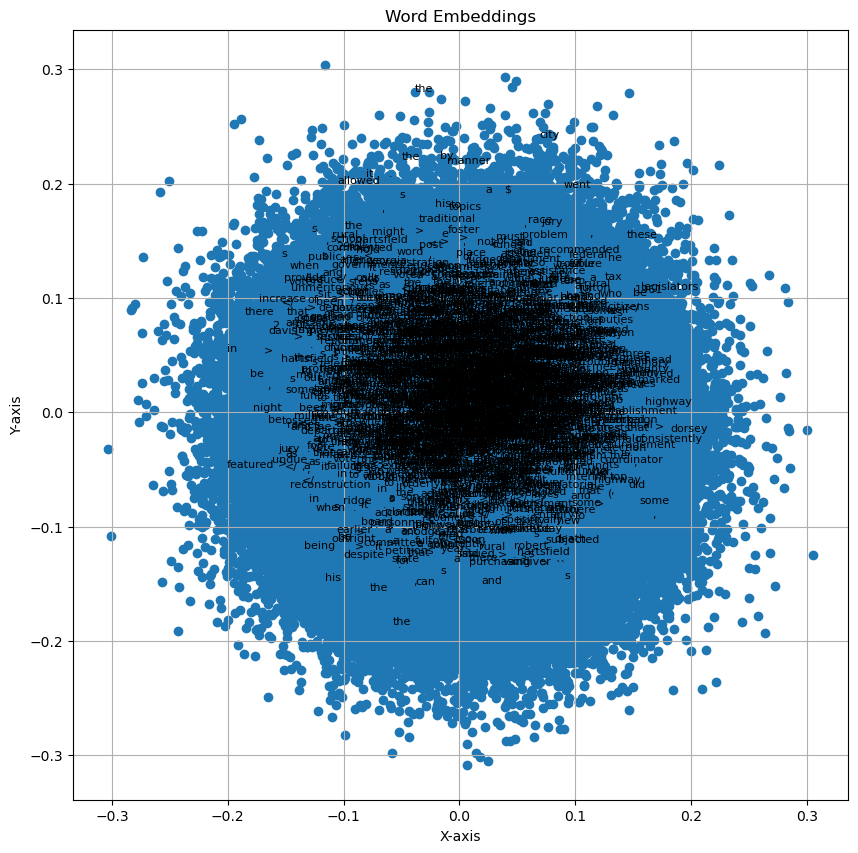

In [13]:
# Normalize the reduced embeddings
M_lengths = np.linalg.norm(M_reduced, axis=1, keepdims=True)
M_reduced_normalized = M_reduced / M_lengths

# Make sure the number of tokens matches the number of vectors
tokens_trimmed = tokens[:M_reduced_normalized.shape[0]]

plot_embeddings(M_reduced_normalized, tokens_trimmed)

### Words with multiple meanings
Polysemes and homonyms are words that have more than one meaning (see [this wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms). Your task is to find a word with at least two different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from both meanings.

For example:
- "leaves" has both the "go_away" and "a_structure_of_a_plant" meanings in the top 10.
- "scoop" has both "handed_waffle_cone" and "lowdown" meanings in the top 10.

You will probably need to try several polysemous or homonymic words before you find one.

Once you discover a word that fits this criterion, state the word and explain the multiple meanings that occur in the top 10. Reflect on why many of the polysemous or homonymic words you tried didn’t work (i.e., why the top-10 most similar words only contain one of the word's meanings).

**Note**: Use the `wv_from_bin.most_similar(word)` function to get the top 10 most similar words. This function ranks all other words in the vocabulary based on their cosine similarity to the given word. For further assistance, you can refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html).

In [14]:
## Your code here
word = "draft"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
top_10_most_similar = wv_from_bin.most_similar(word)
print(top_10_most_similar)

[('drafted', 0.8380459547042847), ('drafts', 0.6813845634460449), ('drafting', 0.6574848890304565), ('proposal', 0.5898616313934326), ('pick', 0.5889190435409546), ('proposals', 0.5629472136497498), ('signed', 0.5611314177513123), ('nfl', 0.555713415145874), ('document', 0.5550253391265869), ('amendments', 0.5514009594917297)]


#### Answer:
A word that we could identify that has several different meanings is draft, which can be used in the context of either drafting a document, drafting a beer or drafting a player in a sport. The top 10 most similar words identified by our function included both words from the world of sports as also words related to the context of drafting a proposal. For example, "proposal", "document" and "signed" are related to the meaning of the word in the context of drafting a document, whereas "pick", "nfl" and "signed" is related to the meaning of the word in the world of sports. 

Before trying "draft" we tried to find such a case with a wide range of words with several meanings such as "bat","bank" and "match", which we did not choose because they only contained words from one of the meanings. This is due to the fact that the word embedding and thus the cosine similarity is based on the contexts of the words. If contexts related to one domain dominated other contexts or if other contexts, which semantically exist, did not occur it would not encode that meaning effectively and would thus have a low cosine similarity.

### Synonyms
When considering **Cosine Similarity**, it's often useful to think of **Cosine Distance**, which is simply 1 - Cosine Similarity.

Find three words \( (w_1, w_2, w_3) \) where:
- \(w_1\) and \(w_2\) are **synonyms**.
- \(w_1\) and \(w_3\) are **antonyms**.

However, you need to find a case where **Cosine Distance** \( (w_1, w_3) < \text{Cosine Distance} (w_1, w_2) \). In other words, the antonym is **closer** to the word than its synonym in the vector space.

For example, "happy" (\(w_1\)) may be closer to "sad" (\(w_3\)) than to "cheerful" (\(w_2\)), which is counter-intuitive since we expect synonyms to be closer than antonyms. 

Once you find such an example, provide a possible explanation for why this result may have occurred.

Use the `wv_from_bin.distance(w1, w2)` function to compute the cosine distance between two words. You can refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html) for further assistance.







In [15]:
## Your code here
words = [["smart","clever","dumb"],["strong","mighty","weak"],["real","true","fake"],
         ["active","lively","passive"],["love","affection","hate"],["sadness","sorrow","happiness"],
         ["artificial","synthetic","natural"],["crazy","mad","sane"],["shy","timid","outgoing"]]

def find_weird_case(words):
    cos_w1_w3 = wv_from_bin.distance(words[0],words[2])
    cos_w1_w2 = wv_from_bin.distance(words[0],words[1])
    if cos_w1_w3<cos_w1_w2:
        return True
    else:
        return False
flag =False    
for word_set in words:
    if find_weird_case(word_set):
        print(f"We found a case! It is {word_set}")
        flag = True
if flag == False:
    print("There was no case yet found we have to try more")
    



We found a case! It is ['strong', 'mighty', 'weak']
We found a case! It is ['active', 'lively', 'passive']
We found a case! It is ['artificial', 'synthetic', 'natural']


#### Answer:
We found three cases where the cosine distance of the word to its antonym was smaller than to its synonym. One such case was "strong", which had a lower cosine distance to "weak" than to "mighty". This could be due to the fact that "strong" and "weak" occur in similar contexts, such as "the man had a strong argument" vs "the man had a weak argument" whereas "the man had a mighty argument" would be odd. Furthermore, synonyms with a low frequency in the corpus could have a biased cosine distance. This reflects the fact that the embeddings of words is based on contextual similarity but not actually semantic similarity, although the two conepts might be closely related in practice.

### Analogies
Word vectors have demonstrated the ability to solve analogies based on their learned semantic relationships. For instance, consider the analogy: 

**"man : grandfather :: woman : x"** 

(Read: man is to grandfather as woman is to x). Using word vectors, we can find the word \(x\) that completes the analogy.

In the example provided, we use the `most_similar` function from the Gensim library. This function identifies words that are most similar to the words in the positive list and most dissimilar to those in the negative list. For analogy solving, it effectively computes:

\[ \text{word}(x) = \text{most similar to} (\text{woman} + \text{grandfather} - \text{man}) \]

The result is the word with the highest cosine similarity to the target vector. You can use this approach to explore various analogies and gain insights into the semantic structure of word vectors.

Refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html) for more details on the `most_similar` function and how word vectors handle analogy-solving tasks.

In [16]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
print(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793), ('granddaughter', 0.7200808525085449), ('daughter', 0.7168302536010742), ('mother', 0.7151536345481873), ('niece', 0.7005682587623596), ('father', 0.6659887433052063), ('aunt', 0.6623408794403076), ('grandson', 0.6618767976760864), ('grandparents', 0.6446609497070312), ('wife', 0.644535481929779)]


### Bias in word vectors
a. **Observation**: Consider the results of a word vector model when queried with analogies involving "man", "woman", and "profession". What are the top results returned by the model for each query?

For "man" and "profession" the top results are "reputation", "professions" and "skills", whereas for "woman" and "profession" the top results are "professions", "practitioner" and "teaching". That there is a difference shows that the top results are biased by cultural connotations to the different genders. 

b. **Analysis**: Do you observe any gender biases in the results? For example, are certain professions more closely associated with "man" or "woman" based on the word vectors? Discuss how word embeddings might perpetuate societal biases present in the training data.

In the results for men "skill" seems to be a frequent word, which is missing from the results for women. This shows that men are associated more with skills than women by the model. Furthermore, it is of note that the most related word to man and profession is reputation, as this highlights that there is a high relation of the words in the corpus, indicating a cultural connectedness of reputation to male professions. Furthermore "business" seems to be highly related to man and profession, whereas for woman and profession "teaching","nursing" and "physicians" seemed to be highly related. This shows that the word embeddings were influenced by cultural norms related to gender and profession, which state that men are more commonly occupied in business, whereas women are more commonly working in the medical and educational sector. 

c. **Reflection**: How might such biases affect the fairness of machine learning models that use word embeddings? Suggest potential strategies for mitigating gender bias in word vector models.

Since word embeddings form the basis for machine learning models they can have huge influences on classifications or predictions of those models, thereby amplifying and perpetuating the existing bias in the data. For example a job recommendation system trained on biased text and thus creating biased embeddings could recommend traditionally "female" jobs to women and vice versa. Through such a model existing biases could be amplified in the real world. In order to mitigate this, existing training sets and corpora could be scanned for biases and cleaned. Furthermore biases could be penalized in the fine-tuning of models. 

In [17]:
print(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
print(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404), ('professions', 0.5178037881851196), ('skill', 0.49046966433525085), ('skills', 0.49005505442619324), ('ethic', 0.4897659420967102), ('business', 0.487585186958313), ('respected', 0.485920250415802), ('practice', 0.4821045696735382), ('regarded', 0.4778572618961334), ('life', 0.4760662019252777)]

[('professions', 0.5957458019256592), ('practitioner', 0.4988412857055664), ('teaching', 0.48292139172554016), ('nursing', 0.48211804032325745), ('vocation', 0.4788965880870819), ('teacher', 0.47160351276397705), ('practicing', 0.4693780839443207), ('educator', 0.46524327993392944), ('physicians', 0.4628995656967163), ('professionals', 0.46013936400413513)]
